In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import seaborn as sn #Plots
import matplotlib.pyplot as plt
import os
print(os.listdir("../input")) #Files

#models and proccesing
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

['2017AllStarGame.csv', 'tabla_nba2016.csv', '2018AllStarGame.csv', '2016AllStarGame.csv', 'tabla_nba2017.csv', 'tabla_nba2018.csv']


In [2]:
# Players statistics from 2016-2018
data2016 = pd.read_csv("../input/tabla_nba2016.csv")
All2016 = pd.read_csv("../input/2016AllStarGame.csv", sep= ';')

data2017 = pd.read_csv("../input/tabla_nba2017.csv")
All2017 = pd.read_csv("../input/2017AllStarGame.csv", sep= ';')
# The players selection method changed after 2017. 
data2018 = pd.read_csv("../input/tabla_nba2018.csv")
All2018 = pd.read_csv("../input/2018AllStarGame.csv", sep= ';')

In [3]:
#drop of duplicated and features that wont be used.
drops = ['Unnamed: 0','Ranking_x.1','Team_x.1','Games_y','Games_x.1','ReboundsxGame','Reboundsx48min',
         'MinutesxGame_x.1','TurnoversxGame_x', 'Assistsx48min','Ranking_y.1', 'Team_y.1', 'Games_y.1',
         'MinutesxGame_y.1','BlockxGame','Blockx48min', 'BlockxFoul', 'Ranking_x.2', 'Team_x.2', 
         'Games_x.2','MinutesxGame_x.2','StealsxGame', 'Stealsx48min','Turnovers_y', 'TurnoversxGame_y',
         'PersonalFouls_y','StealsxTurnover','StealsxFoul', 'Ranking_y.2', 'Team_y.2', 'Games_y.2',
         'MinutesxGame_y.2','PersonalFoulsxGame','PersonalFoulsx48min','Ranking_y','Team_y', 
         'MinutesxGame_y','FieldGoalsxGame','AssistsxGame','AssistxTurnover','PersonalFouls_x',
         'OffensiveReboundsxGame','DefensiveReboundsxGame', 'Ranking_x']

In [4]:
All2018['Player']

0               Kyrie Irving
1              DeMar DeRozan
2               LeBron James
3                Joel Embiid
4      Giannis Antetokounmpo
5               Bradley Beal
6           Goran DragićREP3
7                 Al Horford
8             Kevin LoveINJ3
9                 Kyle Lowry
10            Victor Oladipo
11    Kristaps PorziņģisINJ4
12             John WallINJ2
13        Andre DrummondREP2
14          Kemba WalkerREP4
15             Stephen Curry
16              James Harden
17              Kevin Durant
18      DeMarcus CousinsINJ1
19             Anthony Davis
20         Russell Westbrook
21            Damian Lillard
22            Draymond Green
23        Karl-Anthony Towns
24         LaMarcus Aldridge
25             Klay Thompson
26              Jimmy Butler
27           Paul GeorgeREP1
Name: Player, dtype: object

In [5]:
#Renaming players
All2018.loc[6, 'Player'] = 'Goran Dragić'
All2018.loc[8, 'Player'] = 'Kevin Love'
All2018.loc[11, 'Player'] = 'Kristaps Porziņģis'
All2018.loc[12, 'Player'] = 'John Wall'
All2018.loc[13, 'Player'] = 'Andre Drummond'
All2018.loc[14, 'Player'] = 'Kemba Walker'
All2018.loc[18, 'Player'] = 'DeMarcus Cousins'
All2018.loc[27, 'Player'] = 'Paul George'

In [6]:
#preproccesing for each pair of datasets
def sepandrep(dataset,dataset2, droplist, year):
    #drops
    dataset.drop(columns = droplist  ,inplace= True)
    #split data
    divide = pd.DataFrame(dataset["Player"].str.split(',',expand=True))
    divide.columns=["Player","Position"]
    divide2 = pd.DataFrame(dataset["3Pointers"].str.split('-',expand=True))
    divide2.columns=["3Pointersmin","3Pointersmax"]
    divide3 = pd.DataFrame(dataset["FreeTrows"].str.split('-',expand=True))
    divide3.columns=["FreeTrowsmin","FreeTrowsmax"]
    #Adding split data to the dataset
    dataset["Position"] = divide["Position"]
    dataset["Player"] = divide["Player"]
    dataset["3Pointersmin"] = divide2["3Pointersmin"].astype(float)
    dataset["3Pointersmax"] = divide2["3Pointersmax"].astype(float)
    dataset["FreeTrowsmin"] = divide3["FreeTrowsmin"].astype(float)
    dataset["FreeTrowsmax"] = divide3["FreeTrowsmax"].astype(float)
    #New Features
    dataset["3Pointers"] = (dataset["3Pointersmin"] + dataset["3Pointersmax"])/2
    dataset["FreeTrows"] = (dataset["FreeTrowsmin"] + dataset["FreeTrowsmax"])/2
    #Target
    dataset.loc[dataset['Player'].isin(dataset2['Player']),'AllStars'] = 1
    dataset.loc[dataset['Player'].isin(dataset2['Player']) & dataset2['Starter'] == 1,'Starter'] = 1
    #Filling NaN values, this values correspond to 0s and not to missing data.
    dataset.fillna(0, inplace= True)
    #New feature
    dataset['year'] = year

In [7]:
sepandrep(data2016, All2016, drops, 2016)
sepandrep(data2017, All2017, drops, 2017)
sepandrep(data2018, All2018, drops, 2018)

In [8]:
#Merging 2016, 2017 and 2018 datasets.
data = pd.concat([data2016,data2017,data2018])
data.shape

(1368, 29)

In [9]:
#Features used for the model
data.columns

Index(['Player', 'Team_x', 'Games_x', 'MinutesxGame_x', 'PointsxGame',
       'FieldGoalPercentage', '3Pointers', '3pointersPercentage', 'FreeTrows',
       'FTPercentage', 'OffensiveRebounds', 'DefensiveRebounds', 'Rebounds',
       'Assists', 'Turnovers_x', 'Blocks', 'Steals', 'PersonalFouls',
       'FlagrantFouls', 'TechnicalFouls', 'Ejections', 'Position',
       '3Pointersmin', '3Pointersmax', 'FreeTrowsmin', 'FreeTrowsmax',
       'AllStars', 'Starter', 'year'],
      dtype='object')

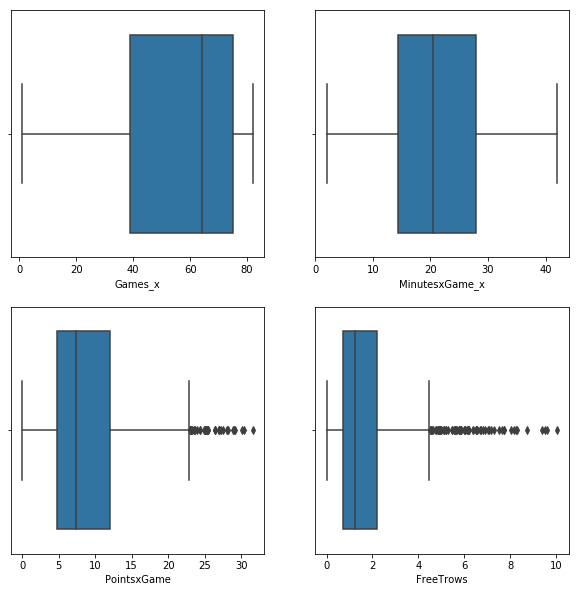

In [10]:
#Some visualizations for numerical variables
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

sn.boxplot(data['Games_x'],ax=ax1)
sn.boxplot(data['MinutesxGame_x'],ax=ax2)
sn.boxplot(data['PointsxGame'],ax=ax3)
sn.boxplot(data['FreeTrows'],ax=ax4)

plt.show()

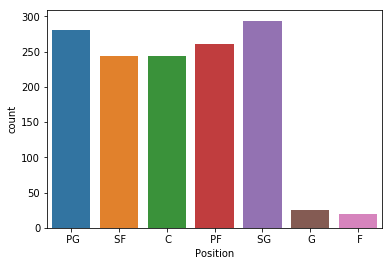

In [11]:
# players positions
# some categories dont seem to be well defined
sn.countplot(data['Position'])

In [12]:
#Dummies and merge
z = pd.get_dummies(data.Position)
frames = [data, z]
datafinal = pd.concat(frames, axis=1)
print(data.shape)

(1368, 29)


In [13]:
#Train and test data
train = datafinal[(datafinal['year'] == 2016) | (datafinal['year'] == 2017)]
test = datafinal[(datafinal['year'] == 2018)]
print(train.shape)
print(test.shape)

(946, 36)
(422, 36)


In [14]:
#selection of data
X_train = train.drop(columns=['Player', 'Team_x', 'AllStars', 'Starter', 'Position'])
y_train = train['AllStars']

X_test = test.drop(columns=['Player', 'Team_x', 'AllStars', 'Starter', 'Position'])
y_test = test['AllStars']

In [15]:
#Normalization
X_train = preprocessing.scale(X_train, axis = 0)
X_test = preprocessing.scale(X_test, axis = 0)

In [17]:
#Random Forest

param_trees = {'n_estimators': [100, 120],
               'max_features': [10, 15, 19, 20, 21, 25],
               'max_depth': [2, 3, 4, 6, 8, 10], 
               'min_samples_leaf':[10, 14, 15, 17],
               'random_state': [0]}

rf = RandomForestClassifier()
rfgrid = GridSearchCV(rf, param_grid=param_trees, cv=3, verbose=1, n_jobs=-1)
rfgrid.fit(X_train, y_train)

print(rfgrid.best_params_)
print(rfgrid.best_score_)

y_pred = rfgrid.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  1.8min finished


{'max_depth': 2, 'max_features': 20, 'min_samples_leaf': 15, 'n_estimators': 100, 'random_state': 0}
0.9661733615221987
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       396
         1.0       0.86      0.69      0.77        26

    accuracy                           0.97       422
   macro avg       0.92      0.84      0.88       422
weighted avg       0.97      0.97      0.97       422



In [19]:
#Gradient Booster

param_bost = {'n_estimators': [100, 120],
              'learning_rate': [0.1, 0.3],
               'max_features': [15, 19, 20, 21, 25, 30],
               'max_depth': [2, 3, 4, 7, 8, 9], 
               'min_samples_leaf':[16, 17, 18],
               'random_state': [0]}

gb = GradientBoostingClassifier()
gbgrid = GridSearchCV(gb, param_grid=param_bost, cv=3, verbose=1, n_jobs=-1)
gbgrid.fit(X_train, y_train)

print(gbgrid.best_params_)
print(gbgrid.best_score_)

y_pred = gbgrid.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 648 candidates, totalling 1944 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1944 out of 1944 | elapsed:  2.1min finished


{'learning_rate': 0.1, 'max_depth': 9, 'max_features': 20, 'min_samples_leaf': 17, 'n_estimators': 120, 'random_state': 0}
0.9682875264270613
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98       396
         1.0       0.73      0.62      0.67        26

    accuracy                           0.96       422
   macro avg       0.85      0.80      0.82       422
weighted avg       0.96      0.96      0.96       422



In [21]:
#xgb

param_xgb = {'eta': [0.05, 0.1, 0.2],
             'max_depth': [2, 3, 4, 6, 8],
             'n_estimators': [200, 250, 300],
             'min_child_weight': [6, 7, 8],
             'colsample_bytree': [0.8, 0.9, 1.0]}

xgb = XGBClassifier()
xgbgrid = GridSearchCV(xgb, param_grid=param_xgb, cv=3, verbose=1, n_jobs=-1)
xgbgrid.fit(X_train, y_train)

print(xgbgrid.best_params_)
print(xgbgrid.best_score_)

y_pred = xgbgrid.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 405 candidates, totalling 1215 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 1215 out of 1215 | elapsed:  1.1min finished


{'colsample_bytree': 0.9, 'eta': 0.05, 'max_depth': 2, 'min_child_weight': 7, 'n_estimators': 200}
0.9661733615221987
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       396
         1.0       0.76      0.62      0.68        26

    accuracy                           0.96       422
   macro avg       0.87      0.80      0.83       422
weighted avg       0.96      0.96      0.96       422



In [23]:
#We select the models with their parameters.
xgb = XGBClassifier(colsample_bytree = 0.9, eta = 0.05, max_depth = 2, min_child_weight = 7, n_estimators = 200)
gb = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 9, max_features = 20, min_samples_leaf = 17, 
                                n_estimators = 120, random_state = 0)
rf = RandomForestClassifier(max_depth = 2, max_features = 20, min_samples_leaf = 15, n_estimators= 100, 
                            random_state= 0)

vote = VotingClassifier(estimators=[('xgb', xgb), ('gb', gb), ('rf', rf)],voting='soft')
vote.fit(X_train, y_train)

y_pred_vote = vote.predict(X_test)
print(classification_report(y_test, y_pred_vote))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       396
         1.0       0.81      0.65      0.72        26

    accuracy                           0.97       422
   macro avg       0.89      0.82      0.85       422
weighted avg       0.97      0.97      0.97       422



In [24]:
#Players in AllStars 2018
results = pd.DataFrame(test['Player'][test['AllStars'] == 1].sort_values())
results['Predicted'] = test['Player'][y_pred_vote == 1].sort_values()
print(results)

                    Player              Predicted
105             Al Horford                    NaN
68          Andre Drummond                    NaN
1            Anthony Davis          Anthony Davis
16            Bradley Beal           Bradley Beal
3           Damian Lillard         Damian Lillard
13           DeMar DeRozan          DeMar DeRozan
8         DeMarcus Cousins       DeMarcus Cousins
149         Draymond Green                    NaN
4    Giannis Antetokounmpo  Giannis Antetokounmpo
0             James Harden           James Harden
18            Jimmy Butler           Jimmy Butler
14             Joel Embiid            Joel Embiid
29               John Wall                    NaN
23      Karl-Anthony Towns                    NaN
19            Kemba Walker                    NaN
6             Kevin Durant           Kevin Durant
42              Kevin Love                    NaN
27           Klay Thompson                    NaN
53              Kyle Lowry                    NaN


         Prob                 Player  Preds  Real
2    0.944686           LeBron James    1.0   1.0
4    0.941022  Giannis Antetokounmpo    1.0   1.0
1    0.932552          Anthony Davis    1.0   1.0
7    0.922245      Russell Westbrook    1.0   1.0
8    0.896768       DeMarcus Cousins    1.0   1.0
0    0.889002           James Harden    1.0   1.0
12   0.888034         Victor Oladipo    1.0   1.0
6    0.879471           Kevin Durant    1.0   1.0
11   0.833262      LaMarcus Aldridge    1.0   1.0
5    0.784517          Stephen Curry    1.0   1.0
20   0.743497            Paul George    1.0   1.0
10   0.734791           Kyrie Irving    1.0   1.0
13   0.734194          DeMar DeRozan    1.0   1.0
14   0.710056            Joel Embiid    1.0   1.0
16   0.651192           Bradley Beal    1.0   1.0
18   0.593700           Jimmy Butler    1.0   1.0
3    0.571063         Damian Lillard    1.0   1.0
19   0.487539           Kemba Walker    0.0   1.0
23   0.368432     Karl-Anthony Towns    0.0   1.0


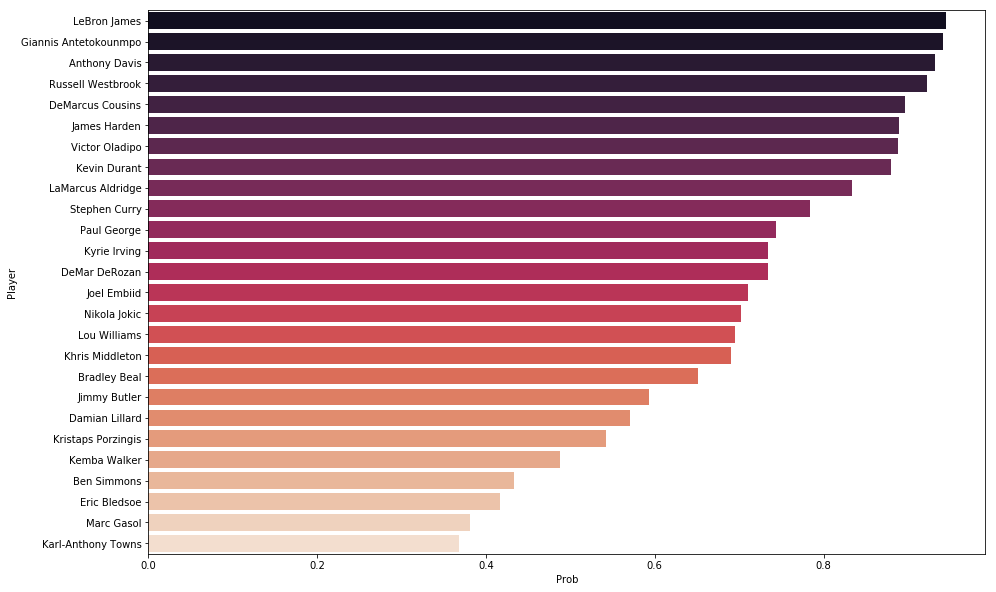

In [25]:
probs = pd.DataFrame()
predprob = vote.predict_proba(X_test)
probs['Prob'] = predprob[:,1]
probs['Player'] = test['Player']
probs['Preds'] = vote.predict(X_test)
probs['Real'] = test['AllStars']
probs.sort_values(by='Prob', inplace=True, ascending=False)

print(probs[probs['Real'] == 1])

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot()
sn.barplot(x=probs['Prob'][:26], y=probs['Player'][:26], palette="rocket", ax=ax1)